### 딥러닝할 게 아니라면 앙상블이 최고!
##### 배깅(Bagging) : 랜덤 포레스트
##### 부스팅(Boostring) : LightGBM

### Desicion Tree : 룰 기반으로 특징 공간을 수직 혹은 수평으로만 나눈다.
##### 피처 스케일링이 필요 없다.
##### depth를 너무 깊게 가져가면 학습 데이터에서만 잘 학습되는 Overfitting 나기 쉽다.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
raw_df = pd.read_csv('creditcard.csv')

In [3]:
df = raw_df.copy()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_features = df.drop('Class', axis=1)
y_label = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, stratify=y_label)

decision_tree = DecisionTreeClassifier(max_depth=8)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8)

### Decision Tree Visualization

In [5]:
from sklearn.tree import export_graphviz

export_graphviz(decision_tree,
                out_file='fraud_detection_tree.dot', 
                feature_names=X_features.columns,
                class_names=['neg', 'pos'],
                rounded=True, 
                filled=True)

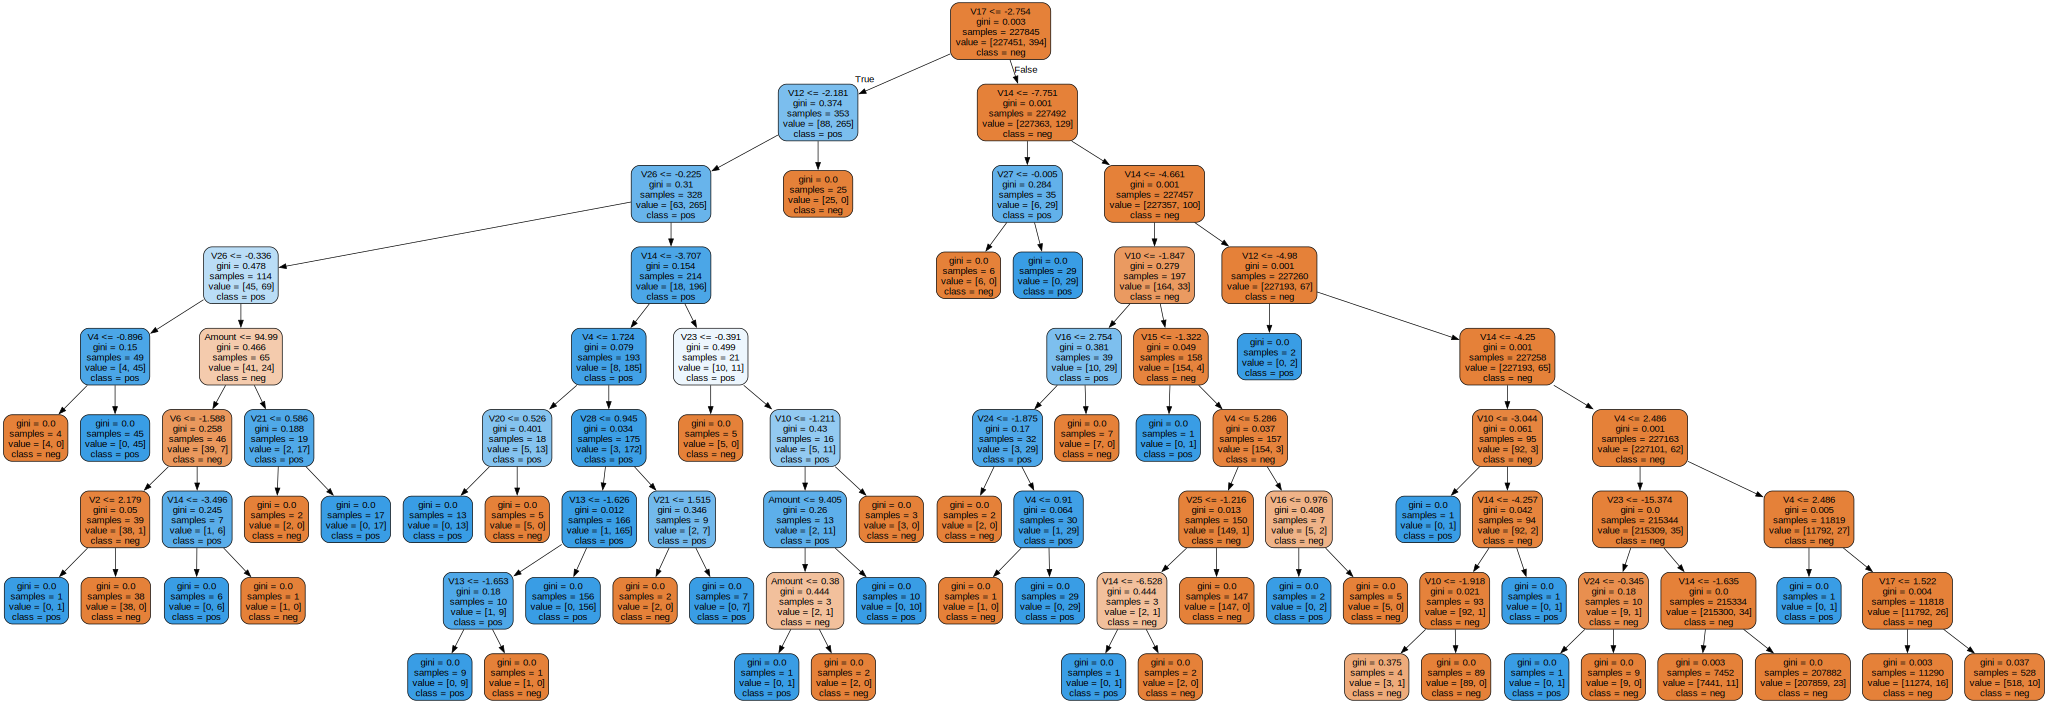

In [6]:
import graphviz
tree = None
with open('fraud_detection_tree.dot') as f:
    tree = f.read()
graphviz.Source(tree)

### 피처 중요도

In [5]:
# 가장 중요한 피처는 뭘까?
feat_idx = decision_tree.feature_importances_.argmax()
X_features.columns[feat_idx]

'V17'

In [6]:
for feature, importance in zip(X_features.columns, decision_tree.feature_importances_):
    print(f'{feature} : {importance:.8f}')

Time : 0.00228483
V1 : 0.00096554
V2 : 0.00000000
V3 : 0.00840977
V4 : 0.00804140
V5 : 0.00000000
V6 : 0.00000000
V7 : 0.00762501
V8 : 0.01001352
V9 : 0.00000000
V10 : 0.09352864
V11 : 0.00294817
V12 : 0.00771400
V13 : 0.00000000
V14 : 0.10496736
V15 : 0.01574057
V16 : 0.02459552
V17 : 0.62416639
V18 : 0.00000000
V19 : 0.00215143
V20 : 0.00000000
V21 : 0.01016485
V22 : 0.00203096
V23 : 0.00677469
V24 : 0.00000000
V25 : 0.00156553
V26 : 0.02961502
V27 : 0.03669681
V28 : 0.00000000
Amount : 0.00000000


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = decision_tree.predict(X_test)

print(f'정밀도(precision) : {precision_score(y_test, y_pred):.2f}')
print(f'재현율(recall) : {recall_score(y_test, y_pred):.2f}')
print(f'F1 점수 : {f1_score(y_test, y_pred):.2f}')

정밀도(precision) : 0.87
재현율(recall) : 0.76
F1 점수 : 0.81


# 최적의 하이퍼 파라미터 찾아보기

In [8]:
# 기본 파라미터 
decision_tree.get_params()
# max_depth : 트리 최대 깊이
# min_samples_leaf : 규제, 자식 노드로 쪼개질 때 자식 노드의 최소 샘플 수, imbalanced 이므로 작게 잡아야 함!
# min_samples_split : 규제, 자식 노드로 나누기 위한 최소 샘플 수, 기본 파라미터 값으로는 2개면 1개씩 쪼갤 수 있다.

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth' : [3, 6, 9, 12, 15, 20, 25]
}
grid = GridSearchCV(decision_tree, param_grid, scoring='recall', cv=5, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(max_depth=8),
             param_grid={'max_depth': [3, 6, 9, 12, 15, 20, 25]},
             scoring='recall', verbose=1)

In [10]:
print(f'최대 평균 재현율 : {grid.best_score_:.2f}')
print(f'최적 최대 깊이 : {grid.best_params_}')

최대 평균 재현율 : 0.77
최적 최대 깊이 : {'max_depth': 9}


### 최적의 모델을 가져올 수 있다.

In [11]:
best_decision_tree = grid.best_estimator_

y_pred_best = best_decision_tree.predict(X_test)

print(f'정밀도(precision) : {precision_score(y_test, y_pred_best):.2f}')
print(f'재현율(recall) : {recall_score(y_test, y_pred_best):.2f}')
print(f'F1 점수 : {f1_score(y_test, y_pred_best):.2f}')

정밀도(precision) : 0.90
재현율(recall) : 0.80
F1 점수 : 0.84


In [12]:
cross_val_df = pd.DataFrame(grid.cv_results_)

In [13]:
cross_val_df.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.605340,0.007501,0.008053,0.000160,3,{'max_depth': 3},0.679487,0.734177,0.746835,0.658228,0.683544,0.700454,0.034050,7
1,3.180326,0.002554,0.008384,0.000140,6,{'max_depth': 6},0.717949,0.860759,0.822785,0.721519,0.708861,0.766375,0.062858,3
2,4.750168,0.006813,0.008480,0.000153,9,{'max_depth': 9},0.743590,0.835443,0.822785,0.721519,0.746835,0.774034,0.045983,1


In [15]:
cross_val_df[['param_max_depth', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score')

,param_max_depth,mean_test_score,rank_test_score
2,9,0.774034,1
3,12,0.766439,2
1,6,0.766375,3
4,15,0.761376,4
6,25,0.753749,5
5,20,0.751152,6
0,3,0.700454,7


### Random Forest
##### Bagging이란?
##### 한 종류의 약한 classifier 여러개의 예측을 종합하여 최종 예측을 만들어 낸다.
##### 이때 사용하는 데이터는 부트스트래핑(Bootstrapping)으로 가져온다. 
##### 부트스트래핑이란 원본 데이터에서 중복 허용으로 여러 샘플을 추출하는 것.
##### 결과적으로 각각의 classifier가 사용하는 데이터는 서로 같지 않다. 다만 데이터의 크기는 원본 데이터와 같음. 

In [16]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100, max_depth=8)
random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=8)

In [17]:
y_pred = random_forest.predict(X_test)

print(f'정밀도(precision) : {precision_score(y_test, y_pred):.2f}')
print(f'재현율(recall) : {recall_score(y_test, y_pred):.2f}')
print(f'F1 점수 : {f1_score(y_test, y_pred):.2f}')

정밀도(precision) : 0.96
재현율(recall) : 0.70
F1 점수 : 0.81


In [18]:
param_grid = {
    'max_depth' : [3, 6, 9, 12, 15, 20, 25]
}
grid = GridSearchCV(random_forest, param_grid, scoring='recall', cv=5, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(max_depth=8),
             param_grid={'max_depth': [3, 6, 9, 12, 15, 20, 25]},
             scoring='recall', verbose=1)

In [19]:
print(f'최대 평균 재현율 : {grid.best_score_:.2f}')
print(f'최적 최대 깊이 : {grid.best_params_}')

최대 평균 재현율 : 0.79
최적 최대 깊이 : {'max_depth': 20}


In [20]:
best_random_forest = grid.best_estimator_

y_pred_best = best_random_forest.predict(X_test)

print(f'정밀도(precision) : {precision_score(y_test, y_pred_best):.2f}')
print(f'재현율(recall) : {recall_score(y_test, y_pred_best):.2f}')
print(f'F1 점수 : {f1_score(y_test, y_pred_best):.2f}')

정밀도(precision) : 0.94
재현율(recall) : 0.74
F1 점수 : 0.83


### Boosting
##### 틀린 예측에 중점을 둬서 '순차적으로' 고쳐나간다. 
##### Gradient Boosting : weight 업데이트를 Gradient Descent(경사 하강법)로 한다.
##### XGBoost : Gradient Boosting 기반, 규제 추가, 빠른 수행 시간, scikit-learn 래핑 클래스 제공

https://www.yes24.com/Product/Goods/108708980

### LightGBM
##### XGBoost 이후에 개발되어 속도도 더 빠르고 메모리도 적게 사용하는데 예측 성능은 비슷

In [23]:
from lightgbm import LGBMClassifier

light_gbm = LGBMClassifier(n_estimators=100, n_jobs=-1, max_depth=8, metric='binary_logloss', boost_from_average=False)
light_gbm.fit(X_train, y_train)

LGBMClassifier(boost_from_average=False, max_depth=8, metric='binary_logloss')

In [24]:
y_pred = light_gbm.predict(X_test)

print(f'정밀도(precision) : {precision_score(y_test, y_pred):.2f}')
print(f'재현율(recall) : {recall_score(y_test, y_pred):.2f}')
print(f'F1 점수 : {f1_score(y_test, y_pred):.2f}')

정밀도(precision) : 0.93
재현율(recall) : 0.79
F1 점수 : 0.85


In [25]:
param_grid = {
    'max_depth': [3, 6, 9, 12, 15, 20, 25]
}
grid = GridSearchCV(light_gbm, param_grid, scoring='recall', cv=5, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5,
             estimator=LGBMClassifier(boost_from_average=False, max_depth=8,
                                      metric='binary_logloss'),
             param_grid={'max_depth': [3, 6, 9, 12, 15, 20, 25]},
             scoring='recall', verbose=1)

In [26]:
print(f'최대 평균 재현율 : {grid.best_score_:.2f}')
print(f'최적 최대 깊이 : {grid.best_params_}')

최대 평균 재현율 : 0.79
최적 최대 깊이 : {'max_depth': 9}


In [27]:
best_light_gbm = grid.best_estimator_

y_pred_best = best_light_gbm.predict(X_test)

print(f'정밀도(precision) : {precision_score(y_test, y_pred_best):.2f}')
print(f'재현율(recall) : {recall_score(y_test, y_pred_best):.2f}')
print(f'F1 점수 : {f1_score(y_test, y_pred_best):.2f}')

정밀도(precision) : 0.95
재현율(recall) : 0.78
F1 점수 : 0.85
